In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from scipy import sparse

In [2]:
# Common Varibles
random_state=42
cv=5
scoring='roc_auc'
verbose=2

I'll be performing classification models on raw data and on OHE.

In [3]:
train_data=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
test_data=test.drop(columns=['id'],axis=1)

In [4]:
y_true=train_data['ACTION']
train_data=train_data.drop(['ACTION'],axis=1)
train_data.shape,y_true.shape

((32769, 9), (32769,))

In [5]:
#splitting the dataset
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(train_data,y_true, test_size=0.2,random_state=100)
x_train.shape,x_test.shape

((26215, 9), (6554, 9))

KNN classifier

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay

In [7]:
knn = KNeighborsClassifier(n_jobs=-1)
from sklearn.model_selection import RandomizedSearchCV
k_range=np.arange(1,100,5)
param_grid=dict(n_neighbors=k_range)
grid=RandomizedSearchCV(knn,param_grid,cv=cv,random_state=random_state,scoring=scoring,verbose=verbose)
grid_serch=grid.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................................n_neighbors=1; total time=   3.2s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.2s
[CV] END .....................................n_neighbors=86; total time=   0.2s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=76; total time=   0.1s
[CV] END .....................................n_

In [8]:
grid_serch.best_params_

{'n_neighbors': 26}

In [9]:
y_pred=grid.predict(x_test)
test_acc_knn=accuracy_score(y_test,y_pred)*100
test_acc_knn
# knn=KNeighborsClassifier(n_neighbors=8)
# knn.fit(x_train, y_train)
# y_pred=knn.predict(x_test)
# test_acc=accuracy_score(y_test,y_pred)*100
# test_acc

94.3240768996033

In [10]:
from sklearn.metrics import roc_auc_score
auc_knn = roc_auc_score(y_test,y_pred)
auc_knn

0.5013404825737265

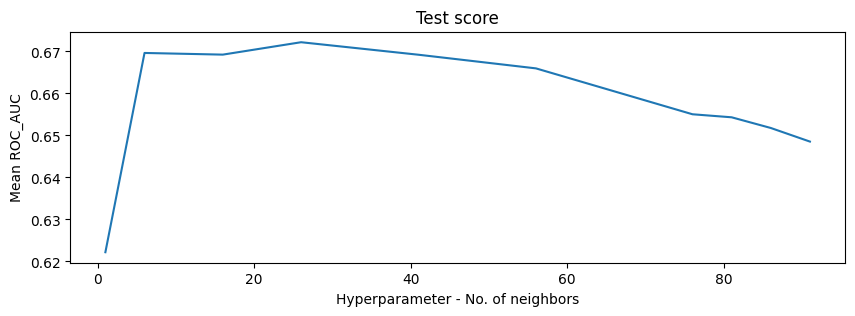

In [11]:
results=pd.DataFrame.from_dict(grid_serch.cv_results_)
results=results.sort_values('param_n_neighbors')
plt.figure(figsize=(10,3))
plt.plot(results['param_n_neighbors'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - No. of neighbors');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [12]:
best_c=grid_serch.best_params_['n_neighbors']
best_c

26

In [13]:
model=KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_data,y_true)

KNeighborsClassifier(n_jobs=-1, n_neighbors=26)

In [14]:
prediction=model.predict_proba(test_data)[:,1]

In [15]:
submit = pd.DataFrame()
submit["Id"] = test["id"]
submit["ACTION"] = prediction
submit.to_csv("knn.csv", index = False)

In [16]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
# y_test.shape,y_pred.shape

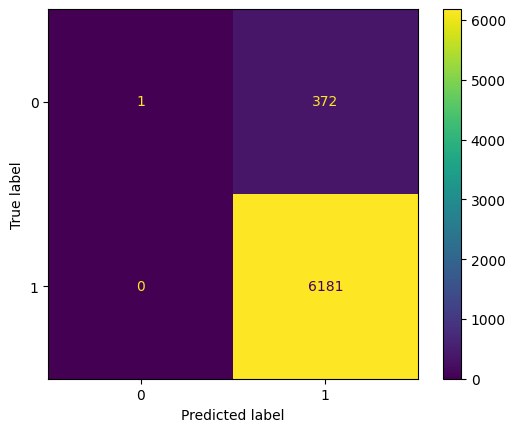

In [17]:
disp.plot()
plt.show()

KNN OHE

In [18]:
from scipy import sparse
train_ohe=sparse.load_npz('train_ohe.npz')
test_ohe=sparse.load_npz('test_ohe.npz')
train_ohe.shape,test_ohe.shape

((32769, 4500), (912363, 4500))

In [19]:
from sklearn.model_selection import GridSearchCV
parameters={'n_neighbors':np.arange(1,100,5)}
clf=RandomizedSearchCV(KNeighborsClassifier(),parameters,cv=cv,verbose=verbose,scoring=scoring,n_jobs=4)
# grid=RandomizedSearchCV(knn,param_grid,cv=cv,random_state=random_state,scoring=scoring,verbose=verbose)
best_model=clf.fit(train_ohe,y_true)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [20]:
result=pd.DataFrame.from_dict(best_model.cv_results_)
result=result.sort_values('param_n_neighbors')
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.009776,0.004781,7.896812,1.231998,6,{'n_neighbors': 6},0.760056,0.794993,0.767923,0.750457,0.784015,0.771489,0.016094,10
5,0.013964,0.005917,19.249006,1.772457,11,{'n_neighbors': 11},0.790634,0.816172,0.795604,0.779872,0.808527,0.798162,0.012880,5
0,0.005784,0.002631,60.297005,21.991515,26,{'n_neighbors': 26},0.808716,0.822521,0.805768,0.774925,0.821470,0.806680,0.017222,1
7,0.015359,0.004746,9.534685,0.544141,31,{'n_neighbors': 31},0.807146,0.822594,0.804889,0.772999,0.816963,0.804918,0.017212,2
1,0.011574,0.008297,27.714738,6.617854,36,{'n_neighbors': 36},0.808658,0.823441,0.802334,0.771946,0.811319,0.803540,0.017218,3
3,0.016661,0.007547,26.657898,10.401250,46,{'n_neighbors': 46},0.804339,0.818778,0.797889,0.765292,0.807178,0.798695,0.018020,4
2,0.014560,0.004534,25.550642,7.389855,51,{'n_neighbors': 51},0.800601,0.818396,0.794158,0.766640,0.801855,0.796330,0.016863,7
6,0.016554,0.006636,15.437945,1.887382,61,{'n_neighbors': 61},0.799612,0.817452,0.791250,0.769539,0.804519,0.796474,0.015921,6
4,0.012766,0.003241,21.321880,2.807017,76,{'n_neighbors': 76},0.796652,0.814884,0.785648,0.765380,0.799800,0.792473,0.016456,8
8,0.013763,0.005406,8.769189,0.191306,81,{'n_neighbors': 81},0.793444,0.812184,0.784589,0.760021,0.800600,0.790167,0.017574,9


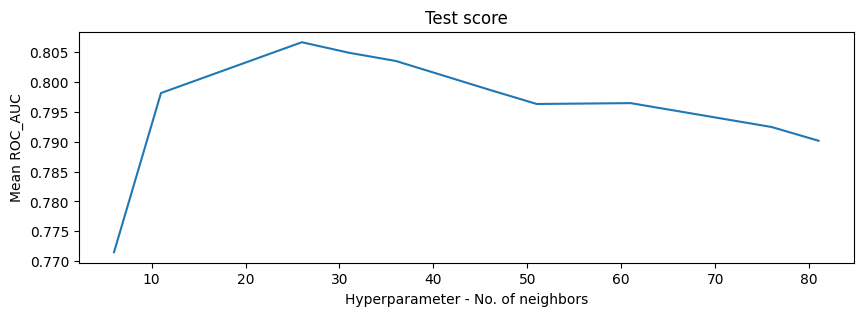

In [21]:
plt.figure(figsize=(10,3))
plt.plot(result['param_n_neighbors'],result['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - No. of neighbors');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [22]:
best_c=best_model.best_params_['n_neighbors']
best_c

26

In [23]:
model=KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_ohe,y_true)

KNeighborsClassifier(n_jobs=-1, n_neighbors=26)

In [24]:
# prediction=model.predict_proba(test_ohe)[:,1]

In [25]:
y_pred=model.predict(train_ohe)
test_acc_knn_ohe=accuracy_score(y_true,y_pred)*100
test_acc_knn_ohe

94.46122860020141

In [26]:
# submit = pd.read_csv('knn.csv')
# # submit["Id"] = test["id"]
# submit["ACTION_KNN_OHE"] = prediction
# submit.to_csv("knn.csv", index = False)

In [27]:
from sklearn.metrics import roc_auc_score
auc_knn_ohe = roc_auc_score(y_true, y_pred)
auc_knn_ohe

0.5320029559363451

In [75]:
from prettytable import PrettyTable
x = PrettyTable(['Model', 'Feature', 'Accuracy', 'ROC_AUC'])
x.add_row(['KNeighborsClassifier', '-', round(test_acc_knn,5), round(auc_knn,5)])
x.add_row(['KNeighborsClassifier','ohe', round(test_acc_knn_ohe,5), round(auc_knn_ohe,6)])
print(x)

+----------------------+---------+----------+----------+
|        Model         | Feature | Accuracy | ROC_AUC  |
+----------------------+---------+----------+----------+
| KNeighborsClassifier |    -    | 94.32408 | 0.50134  |
| KNeighborsClassifier |   ohe   | 94.46123 | 0.532003 |
+----------------------+---------+----------+----------+


Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

In [30]:
C_val = uniform(loc=0, scale=4)
lr=LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf=RandomizedSearchCV(lr,parameters,verbose=verbose,cv=cv,random_state=random_state,scoring=scoring,n_iter=100,n_jobs=-1)
best_model=clf.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [31]:
best_c=best_model.best_params_['C']
best_c

0.08233797718320979

In [32]:
result=pd.DataFrame.from_dict(best_model.cv_results_)
result.sort_values('param_C')
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.378630,0.055390,0.009378,0.001349,1.49816,{'C': 1.49816047538945},0.529549,0.542286,0.500633,0.511880,0.550482,0.526966,0.018522,57
1,0.372543,0.057820,0.008976,0.000630,3.802857,{'C': 3.8028572256396647},0.529549,0.542296,0.500632,0.511880,0.550482,0.526968,0.018524,11
2,0.358905,0.054822,0.009177,0.000744,2.927976,{'C': 2.9279757672456204},0.529549,0.542296,0.500631,0.511880,0.550482,0.526968,0.018525,30
3,0.387286,0.064384,0.010282,0.001081,2.394634,{'C': 2.3946339367881464},0.529549,0.542284,0.500631,0.511880,0.550482,0.526965,0.018523,87
4,0.405055,0.053701,0.009084,0.000663,0.624075,{'C': 0.6240745617697461},0.529549,0.542293,0.500631,0.511880,0.550482,0.526967,0.018524,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.390478,0.046929,0.009175,0.000745,1.975182,{'C': 1.975182385457563},0.529549,0.542284,0.500632,0.511880,0.550482,0.526966,0.018522,77
96,0.415201,0.071202,0.008978,0.000632,2.090931,{'C': 2.0909313175279762},0.529549,0.542285,0.500632,0.511880,0.550482,0.526966,0.018522,70
97,0.414111,0.062199,0.008880,0.000493,1.710164,{'C': 1.7101640734341985},0.529549,0.542286,0.500632,0.511880,0.550482,0.526966,0.018523,57
98,0.396962,0.064978,0.007182,0.001164,0.101677,{'C': 0.10167650697638075},0.529549,0.542257,0.500660,0.511879,0.550482,0.526965,0.018510,87


In [33]:
model=LogisticRegression(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',n_jobs=-1)
model.fit(train_data,y_true)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=0.08233797718320979, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [34]:
y_pred=model.predict(x_test)
test_acc_lr=accuracy_score(y_test,y_pred)*100
auc_lr = roc_auc_score(y_test,y_pred)
test_acc_lr,auc_lr

(50.15257857796765, 0.5304092841810044)

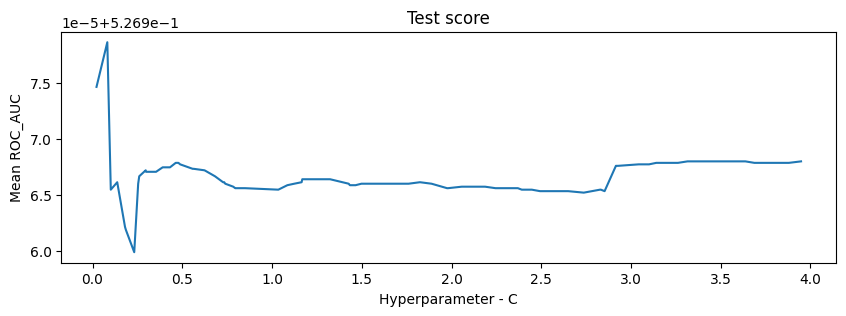

In [35]:
results=pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
plt.figure(figsize=(10,3))
plt.plot(results['param_C'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - C');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

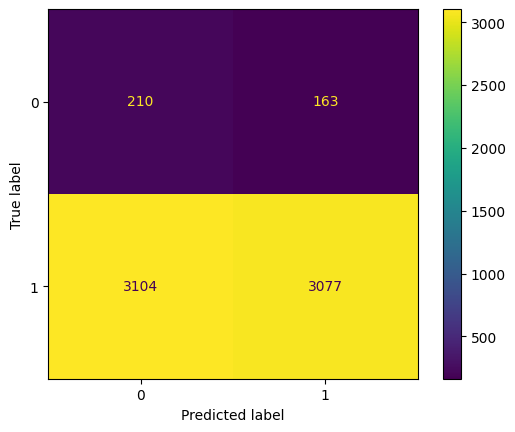

In [36]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)
disp.plot()
plt.show()

Logistic Regression OHE

In [37]:
train_ohe.shape,test_ohe.shape,y_true.shape

((32769, 4500), (912363, 4500), (32769,))

In [38]:
C_val = uniform(loc=0, scale=4)
lr=LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf=RandomizedSearchCV(lr,parameters,verbose=verbose,cv=cv,random_state=random_state,scoring=scoring,n_iter=100,n_jobs=-1)
best_model=clf.fit(train_ohe,y_true)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [39]:
best_c=best_model.best_params_['C']
best_c

0.7948627261366896

In [40]:
result=pd.DataFrame.from_dict(best_model.cv_results_)
result=result.sort_values('param_C')
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.359144,0.018063,0.006981,0.000631,0.022088,{'C': 0.022088468494409597},0.827415,0.833777,0.808035,0.814502,0.841708,0.825087,0.012329,100
10,0.522660,0.044222,0.006184,0.000399,0.082338,{'C': 0.08233797718320979},0.864374,0.867161,0.845380,0.846580,0.866256,0.857950,0.009822,99
98,0.687189,0.092516,0.006583,0.000489,0.101677,{'C': 0.10167650697638075},0.868155,0.870643,0.849562,0.850073,0.868926,0.861472,0.009551,98
42,0.750133,0.119015,0.006782,0.000747,0.137554,{'C': 0.13755408446087358},0.872632,0.874930,0.855066,0.854638,0.872126,0.865878,0.009053,97
58,0.806174,0.128414,0.006384,0.000489,0.180909,{'C': 0.18090915564215226},0.875813,0.877965,0.859005,0.857691,0.874480,0.868991,0.008771,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2.070548,0.126947,0.006583,0.000490,3.802857,{'C': 3.8028572256396647},0.877215,0.881082,0.863760,0.853882,0.876353,0.870458,0.010128,90
34,2.029165,0.093574,0.006983,0.000893,3.862528,{'C': 3.8625281322982374},0.877135,0.880991,0.863656,0.853775,0.876278,0.870367,0.010138,91
50,2.002646,0.147376,0.006781,0.000399,3.878339,{'C': 3.8783385110582342},0.877105,0.880956,0.863630,0.853730,0.876245,0.870333,0.010142,92
11,1.910550,0.105065,0.006785,0.001164,3.879639,{'C': 3.8796394086479773},0.877091,0.880962,0.863608,0.853724,0.876251,0.870327,0.010146,93


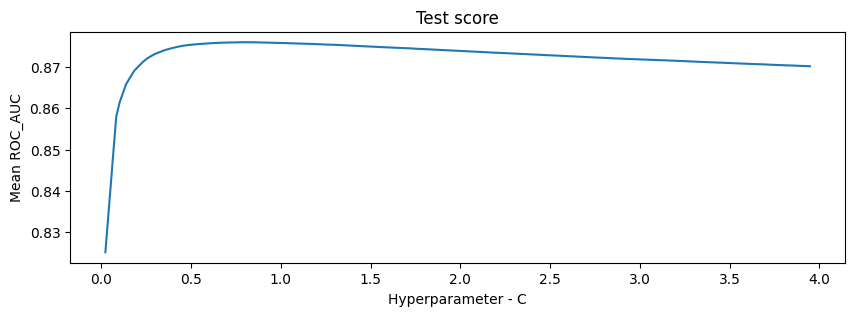

In [41]:
plt.figure(figsize=(10,3))
plt.plot(result['param_C'],result['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - C');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [42]:
model=LogisticRegression(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',n_jobs=-1)
model.fit(train_ohe,y_true)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


LogisticRegression(C=0.7948627261366896, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [43]:
y_pred=model.predict(train_ohe)
test_acc_lr_ohe=accuracy_score(y_true,y_pred)*100
auc_lr_ohe = roc_auc_score(y_true, y_pred)
test_acc_lr_ohe,auc_lr_ohe

(91.88562360767799, 0.9413502628159217)

In [70]:
from prettytable import PrettyTable
x = PrettyTable(['Model', 'Feature', 'Accuracy', 'ROC_AUC'])
x.add_row(['Logistic Regression', '-', round(test_acc_knn,5), round(auc_lr,5)])
x.add_row(['Logistic Regression','ohe', round(test_acc_lr_ohe,5), round(auc_lr_ohe,5)])
print(x)

+---------------------+---------+----------+---------+
|        Model        | Feature | Accuracy | ROC_AUC |
+---------------------+---------+----------+---------+
| Logistic Regression |    -    | 94.32408 | 0.53041 |
| Logistic Regression |   ohe   | 91.88562 | 0.94135 |
+---------------------+---------+----------+---------+


Decision Tree

In [45]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [46]:
param_dist = {"max_depth": [3, None],"max_features": randint(1, 9),"min_samples_leaf": randint(1, 9),"criterion": ["gini", "entropy"]}

In [47]:
tree = DecisionTreeClassifier()
clf=RandomizedSearchCV(tree, param_dist,verbose=verbose,cv=cv,random_state=random_state,scoring=scoring,n_iter=100,n_jobs=-1)
best_model=clf.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [48]:
from sklearn.metrics import roc_auc_score

In [49]:
y_pred=best_model.predict(x_test)
test_acc_dt=accuracy_score(y_test,y_pred)*100
auc_dt = roc_auc_score(y_test,y_pred)
test_acc_dt,auc_dt

(93.37808971620385, 0.6109477586983896)

In [50]:
best_model.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 8}

In [51]:
param_max_features=best_model.best_params_['max_features']
param_max_features

4

In [52]:
results=pd.DataFrame.from_dict(best_model.cv_results_)
# results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.115406,0.003053,0.006784,0.000745,gini,None,5,7,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.758214,0.763180,0.730374,0.743648,0.748325,0.748748,0.011504,14
1,0.121294,0.007299,0.006984,0.000630,gini,None,5,5,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.761435,0.771153,0.717616,0.754949,0.741252,0.749281,0.018576,12
2,0.073842,0.012222,0.007977,0.002524,gini,None,3,7,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.737528,0.755565,0.734969,0.748829,0.742213,0.743821,0.007531,20
3,0.044514,0.002329,0.006782,0.000747,gini,3,8,5,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.616580,0.642652,0.587848,0.599319,0.603934,0.610067,0.018714,60
4,0.203802,0.015436,0.007380,0.001353,entropy,None,8,3,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.740595,0.762807,0.699834,0.730269,0.739489,0.734599,0.020411,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.116110,0.007142,0.008777,0.003591,entropy,None,4,5,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.738072,0.772939,0.735550,0.732243,0.747071,0.745175,0.014729,19
96,0.082501,0.012917,0.007183,0.000746,gini,None,3,7,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.736357,0.757211,0.746783,0.758999,0.757510,0.751372,0.008677,8
97,0.025339,0.002120,0.007579,0.002410,gini,3,3,3,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.597587,0.654726,0.588161,0.551598,0.587261,0.595866,0.033348,84
98,0.090677,0.003919,0.006381,0.000489,entropy,None,3,4,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.729212,0.729529,0.718291,0.702740,0.723244,0.720603,0.009851,43


In [53]:
results['param_max_features'].unique()

array([5, 3, 8, 2, 6, 1, 7, 4], dtype=object)

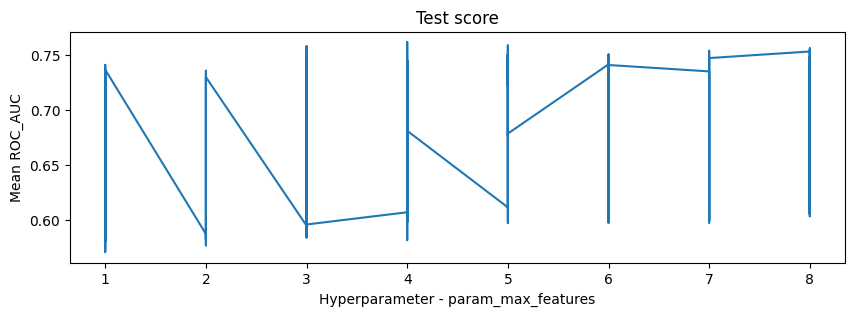

In [54]:
results=results.sort_values('param_max_features')
plt.figure(figsize=(10,3))
plt.plot(results['param_max_features'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - param_max_features');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [55]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=6, max_features=7)
model.fit(train_data,y_true)

DecisionTreeClassifier(criterion='entropy', max_features=7, min_samples_leaf=6)

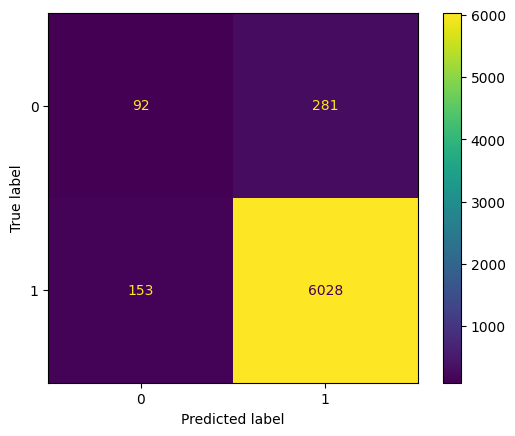

In [56]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

Decision tree OHE

In [57]:
param_dist = {"max_depth": [3, None],"max_features": randint(1, 9),"min_samples_leaf": randint(1, 9),"criterion": ["gini", "entropy"]}
tree = DecisionTreeClassifier()
clf=RandomizedSearchCV(tree, param_dist,verbose=verbose,cv=cv,random_state=random_state,scoring=scoring,n_iter=100,n_jobs=-1)
best_model=clf.fit(train_ohe,y_true)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [58]:
results=pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_max_features')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,0.010873,0.001678,0.004890,0.000193,entropy,None,1,3,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.500162,0.501053,0.501477,0.503574,0.500000,0.501253,0.001283,88
71,0.010372,0.001353,0.005290,0.001394,entropy,3,1,5,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.500000,0.500000,0.500386,0.511687,0.500000,0.502415,0.004639,69
44,0.011370,0.001494,0.004491,0.001003,gini,3,1,3,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.501053,0.500000,0.500729,0.500000,0.500162,0.500389,0.000427,99
82,2.198303,0.132920,0.025145,0.004947,entropy,None,1,1,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.669750,0.664691,0.642896,0.639292,0.674682,0.658262,0.014415,20
69,0.015958,0.005240,0.004787,0.000746,gini,None,1,2,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.501579,0.514206,0.507646,0.515709,0.515220,0.510872,0.005480,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,0.230224,0.047134,0.014561,0.007817,gini,None,8,5,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.687258,0.721013,0.711413,0.758575,0.707511,0.717154,0.023453,3
43,0.111419,0.070534,0.008179,0.002476,gini,None,8,6,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.549007,0.598025,0.701608,0.610269,0.689274,0.629637,0.057640,23
54,0.010276,0.000400,0.004589,0.000798,entropy,3,8,7,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.506877,0.499919,0.504159,0.502187,0.502236,0.503076,0.002328,56
22,0.182840,0.042771,0.010475,0.002524,entropy,None,8,4,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.685909,0.731085,0.681283,0.642453,0.652268,0.678600,0.031033,12


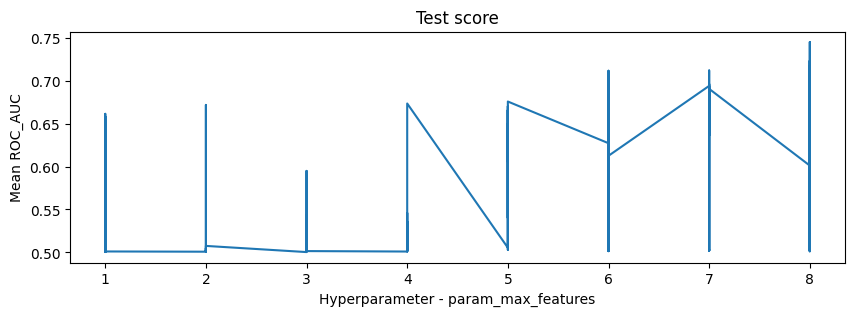

In [59]:
plt.figure(figsize=(10,3))
plt.plot(results['param_max_features'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - param_max_features');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [60]:
best_model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 8,
 'min_samples_leaf': 3}

In [65]:
model = DecisionTreeClassifier(criterion= 'entropy',max_features=8,min_samples_leaf= 3)
model.fit(train_data,y_true)

DecisionTreeClassifier(criterion='entropy', max_features=8, min_samples_leaf=3)

In [66]:
y_pred=model.predict(x_test)
test_acc_dt_ohe=accuracy_score(y_test,y_pred)*100
auc_dt_ohe= roc_auc_score(y_test,y_pred)
test_acc_dt_ohe,auc_dt_ohe

(96.97894415624046, 0.8567646332941953)

In [68]:
from prettytable import PrettyTable
x = PrettyTable(['Model', 'Feature', 'Accuracy', 'ROC_AUC'])
x.add_row(['Decision Tree', '-', round(test_acc_dt,5), round(auc_dt,5)])
x.add_row(['Decision Tree','ohe', round(test_acc_dt_ohe,5), round(auc_dt_ohe,5)])
print(x)

+---------------+---------+----------+---------+
|     Model     | Feature | Accuracy | ROC_AUC |
+---------------+---------+----------+---------+
| Decision Tree |    -    | 93.37809 | 0.61095 |
| Decision Tree |   ohe   | 96.97894 | 0.85676 |
+---------------+---------+----------+---------+


Random Forest